In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jutepest/sample_submission.csv
/kaggle/input/jutepest/train.csv
/kaggle/input/jutepest/test.csv
/kaggle/input/jutepest/train_images/data_2198.jpg
/kaggle/input/jutepest/train_images/data_4627.jpg
/kaggle/input/jutepest/train_images/data_4335.jpg
/kaggle/input/jutepest/train_images/data_3267.jpg
/kaggle/input/jutepest/train_images/data_6807.jpg
/kaggle/input/jutepest/train_images/data_5147.jpg
/kaggle/input/jutepest/train_images/data_4768.jpg
/kaggle/input/jutepest/train_images/data_3090.jpg
/kaggle/input/jutepest/train_images/data_2961.jpg
/kaggle/input/jutepest/train_images/data_4147.jpg
/kaggle/input/jutepest/train_images/data_548.jpg
/kaggle/input/jutepest/train_images/data_2240.jpg
/kaggle/input/jutepest/train_images/data_1699.jpg
/kaggle/input/jutepest/train_images/data_2939.jpg
/kaggle/input/jutepest/train_images/data_4276.jpg
/kaggle/input/jutepest/train_images/data_2919.jpg
/kaggle/input/jutepest/train_images/data_3086.jpg
/kaggle/input/jutepest/train_images/data_

In [3]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [4]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [5]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
])


In [6]:
# Define custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [7]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

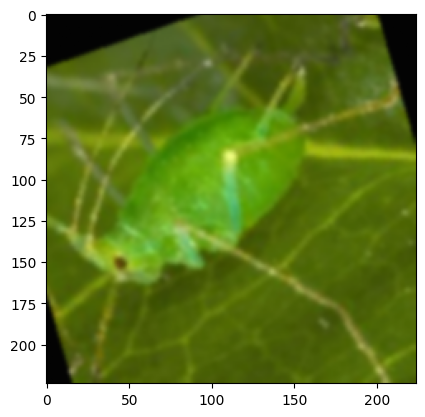

In [8]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [9]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### ResNet


In [10]:
# Define a pre-trained model (e.g., ResNet) and customize it
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.model = models.resnet50(pretrained=False)  # Set pretrained to False to avoid using pre-trained weights
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

In [11]:
model = CustomResNet(num_classes=17)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # L2 regularization
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
CustomResNet                                  [32, 17]                  --
├─ResNet: 1-1                                 [32, 17]                  --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [32, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [32, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [32, 512, 28, 28]         379,392

In [13]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

CustomResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [14]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    acc = (true == pred.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [15]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    pred = pred.cpu().numpy()
    return f1_score(true, pred, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [16]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [17]:
# Initialize training and validation statistics
train_loss = []
train_accuracy = []
train_f1_score = []
val_loss = []
val_accuracy = []
val_f1_score = []
epochs = 100
patience = 6

In [18]:
# Training loop
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} due to early stopping')
            break

    lr_scheduler.step()

Epoch 1/100: 100%|██████████| 154/154 [01:51<00:00,  1.39batch/s, Training Loss=2.82, Training Accuracy=11.1, Training F1 Score=0.0921]


Epoch 1/100, Training Loss: 2.8240, Training Accuracy: 11.12%, Training F1 Score: 0.09
Validation Loss: 2.5984, Validation Accuracy: 17.57%, Validation F1 Score: 0.14, Epoch Duration: 135.31 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=2.7, Training Accuracy=14.5, Training F1 Score=0.136] 


Epoch 2/100, Training Loss: 2.7020, Training Accuracy: 14.50%, Training F1 Score: 0.14
Validation Loss: 2.6259, Validation Accuracy: 15.85%, Validation F1 Score: 0.13, Epoch Duration: 112.70 seconds


Epoch 3/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=2.66, Training Accuracy=16.7, Training F1 Score=0.159]


Epoch 3/100, Training Loss: 2.6632, Training Accuracy: 16.75%, Training F1 Score: 0.16
Validation Loss: 2.5140, Validation Accuracy: 21.04%, Validation F1 Score: 0.18, Epoch Duration: 110.27 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [01:31<00:00,  1.67batch/s, Training Loss=2.61, Training Accuracy=18.2, Training F1 Score=0.176]


Epoch 4/100, Training Loss: 2.6099, Training Accuracy: 18.23%, Training F1 Score: 0.18
Validation Loss: 2.4144, Validation Accuracy: 24.56%, Validation F1 Score: 0.21, Epoch Duration: 110.12 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=2.57, Training Accuracy=20, Training F1 Score=0.195]  


Epoch 5/100, Training Loss: 2.5688, Training Accuracy: 20.02%, Training F1 Score: 0.19
Validation Loss: 2.3083, Validation Accuracy: 26.19%, Validation F1 Score: 0.24, Epoch Duration: 110.24 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [01:34<00:00,  1.63batch/s, Training Loss=2.51, Training Accuracy=21.4, Training F1 Score=0.212]


Epoch 6/100, Training Loss: 2.5056, Training Accuracy: 21.43%, Training F1 Score: 0.21
Validation Loss: 2.1640, Validation Accuracy: 33.92%, Validation F1 Score: 0.31, Epoch Duration: 113.43 seconds
Best model saved


Epoch 7/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=2.43, Training Accuracy=24.3, Training F1 Score=0.24] 


Epoch 7/100, Training Loss: 2.4275, Training Accuracy: 24.32%, Training F1 Score: 0.24
Validation Loss: 2.1446, Validation Accuracy: 33.65%, Validation F1 Score: 0.32, Epoch Duration: 111.55 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=2.37, Training Accuracy=26, Training F1 Score=0.263]  


Epoch 8/100, Training Loss: 2.3721, Training Accuracy: 26.04%, Training F1 Score: 0.26
Validation Loss: 2.0297, Validation Accuracy: 39.16%, Validation F1 Score: 0.37, Epoch Duration: 111.94 seconds
Best model saved


Epoch 9/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=2.33, Training Accuracy=27.4, Training F1 Score=0.272]


Epoch 9/100, Training Loss: 2.3341, Training Accuracy: 27.38%, Training F1 Score: 0.27
Validation Loss: 1.9360, Validation Accuracy: 41.22%, Validation F1 Score: 0.39, Epoch Duration: 111.59 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=2.31, Training Accuracy=27.2, Training F1 Score=0.279]


Epoch 10/100, Training Loss: 2.3086, Training Accuracy: 27.23%, Training F1 Score: 0.28
Validation Loss: 1.9304, Validation Accuracy: 42.36%, Validation F1 Score: 0.41, Epoch Duration: 110.61 seconds
Model saved at epoch 10
Best model saved


Epoch 11/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=2.21, Training Accuracy=30, Training F1 Score=0.307]  


Epoch 11/100, Training Loss: 2.2117, Training Accuracy: 30.01%, Training F1 Score: 0.31
Validation Loss: 1.7423, Validation Accuracy: 49.28%, Validation F1 Score: 0.48, Epoch Duration: 111.26 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=2.19, Training Accuracy=30.5, Training F1 Score=0.316]


Epoch 12/100, Training Loss: 2.1919, Training Accuracy: 30.48%, Training F1 Score: 0.32
Validation Loss: 1.7003, Validation Accuracy: 49.68%, Validation F1 Score: 0.48, Epoch Duration: 110.91 seconds
Best model saved


Epoch 13/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=2.17, Training Accuracy=30.9, Training F1 Score=0.317]


Epoch 13/100, Training Loss: 2.1686, Training Accuracy: 30.94%, Training F1 Score: 0.32
Validation Loss: 1.6886, Validation Accuracy: 50.85%, Validation F1 Score: 0.50, Epoch Duration: 111.81 seconds
Best model saved


Epoch 14/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=2.11, Training Accuracy=32.9, Training F1 Score=0.337]


Epoch 14/100, Training Loss: 2.1145, Training Accuracy: 32.91%, Training F1 Score: 0.34
Validation Loss: 1.6032, Validation Accuracy: 53.59%, Validation F1 Score: 0.52, Epoch Duration: 111.16 seconds
Best model saved


Epoch 15/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=2.1, Training Accuracy=33.1, Training F1 Score=0.339] 


Epoch 15/100, Training Loss: 2.0997, Training Accuracy: 33.08%, Training F1 Score: 0.34
Validation Loss: 1.5212, Validation Accuracy: 57.13%, Validation F1 Score: 0.56, Epoch Duration: 111.35 seconds
Best model saved


Epoch 16/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=2.03, Training Accuracy=34.3, Training F1 Score=0.358]


Epoch 16/100, Training Loss: 2.0307, Training Accuracy: 34.34%, Training F1 Score: 0.36
Validation Loss: 1.4558, Validation Accuracy: 60.65%, Validation F1 Score: 0.60, Epoch Duration: 111.25 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.98, Training Accuracy=35.9, Training F1 Score=0.37] 


Epoch 17/100, Training Loss: 1.9763, Training Accuracy: 35.88%, Training F1 Score: 0.37
Validation Loss: 1.3881, Validation Accuracy: 62.01%, Validation F1 Score: 0.60, Epoch Duration: 111.91 seconds
Best model saved


Epoch 18/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.98, Training Accuracy=36.5, Training F1 Score=0.379]


Epoch 18/100, Training Loss: 1.9817, Training Accuracy: 36.51%, Training F1 Score: 0.38
Validation Loss: 1.4083, Validation Accuracy: 60.50%, Validation F1 Score: 0.58, Epoch Duration: 113.53 seconds


Epoch 19/100: 100%|██████████| 154/154 [01:34<00:00,  1.62batch/s, Training Loss=1.97, Training Accuracy=36.4, Training F1 Score=0.376]


Epoch 19/100, Training Loss: 1.9669, Training Accuracy: 36.42%, Training F1 Score: 0.38
Validation Loss: 1.3744, Validation Accuracy: 60.22%, Validation F1 Score: 0.59, Epoch Duration: 113.29 seconds
Best model saved


Epoch 20/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.93, Training Accuracy=37.1, Training F1 Score=0.387]


Epoch 20/100, Training Loss: 1.9283, Training Accuracy: 37.09%, Training F1 Score: 0.39
Validation Loss: 1.2905, Validation Accuracy: 65.37%, Validation F1 Score: 0.65, Epoch Duration: 112.40 seconds
Model saved at epoch 20
Best model saved


Epoch 21/100: 100%|██████████| 154/154 [01:33<00:00,  1.64batch/s, Training Loss=1.9, Training Accuracy=37.2, Training F1 Score=0.386] 


Epoch 21/100, Training Loss: 1.9017, Training Accuracy: 37.20%, Training F1 Score: 0.39
Validation Loss: 1.2288, Validation Accuracy: 68.20%, Validation F1 Score: 0.67, Epoch Duration: 113.08 seconds
Best model saved


Epoch 22/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.86, Training Accuracy=39, Training F1 Score=0.406]  


Epoch 22/100, Training Loss: 1.8641, Training Accuracy: 39.02%, Training F1 Score: 0.41
Validation Loss: 1.1639, Validation Accuracy: 71.30%, Validation F1 Score: 0.70, Epoch Duration: 112.13 seconds
Best model saved


Epoch 23/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.85, Training Accuracy=38.4, Training F1 Score=0.398]


Epoch 23/100, Training Loss: 1.8458, Training Accuracy: 38.37%, Training F1 Score: 0.40
Validation Loss: 1.1692, Validation Accuracy: 69.38%, Validation F1 Score: 0.69, Epoch Duration: 111.63 seconds


Epoch 24/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.79, Training Accuracy=40.3, Training F1 Score=0.421]


Epoch 24/100, Training Loss: 1.7936, Training Accuracy: 40.27%, Training F1 Score: 0.42
Validation Loss: 1.1212, Validation Accuracy: 69.96%, Validation F1 Score: 0.69, Epoch Duration: 110.51 seconds
Best model saved


Epoch 25/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.82, Training Accuracy=39.3, Training F1 Score=0.409]


Epoch 25/100, Training Loss: 1.8206, Training Accuracy: 39.32%, Training F1 Score: 0.41
Validation Loss: 1.1077, Validation Accuracy: 71.73%, Validation F1 Score: 0.70, Epoch Duration: 111.36 seconds
Best model saved


Epoch 26/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.77, Training Accuracy=40.5, Training F1 Score=0.418]


Epoch 26/100, Training Loss: 1.7654, Training Accuracy: 40.48%, Training F1 Score: 0.42
Validation Loss: 1.0468, Validation Accuracy: 74.03%, Validation F1 Score: 0.73, Epoch Duration: 112.62 seconds
Best model saved


Epoch 27/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=1.72, Training Accuracy=41.8, Training F1 Score=0.434]


Epoch 27/100, Training Loss: 1.7167, Training Accuracy: 41.84%, Training F1 Score: 0.43
Validation Loss: 0.9845, Validation Accuracy: 77.14%, Validation F1 Score: 0.76, Epoch Duration: 114.60 seconds
Best model saved


Epoch 28/100: 100%|██████████| 154/154 [01:34<00:00,  1.62batch/s, Training Loss=1.75, Training Accuracy=41.2, Training F1 Score=0.428]


Epoch 28/100, Training Loss: 1.7460, Training Accuracy: 41.17%, Training F1 Score: 0.43
Validation Loss: 0.9814, Validation Accuracy: 76.45%, Validation F1 Score: 0.76, Epoch Duration: 113.55 seconds
Best model saved


Epoch 29/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.68, Training Accuracy=43, Training F1 Score=0.454]  


Epoch 29/100, Training Loss: 1.6805, Training Accuracy: 42.97%, Training F1 Score: 0.45
Validation Loss: 0.9766, Validation Accuracy: 75.41%, Validation F1 Score: 0.74, Epoch Duration: 111.26 seconds
Best model saved


Epoch 30/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.72, Training Accuracy=41.2, Training F1 Score=0.437]


Epoch 30/100, Training Loss: 1.7192, Training Accuracy: 41.21%, Training F1 Score: 0.44
Validation Loss: 0.9565, Validation Accuracy: 75.89%, Validation F1 Score: 0.74, Epoch Duration: 112.54 seconds
Model saved at epoch 30
Best model saved


Epoch 31/100: 100%|██████████| 154/154 [01:33<00:00,  1.64batch/s, Training Loss=1.66, Training Accuracy=42.8, Training F1 Score=0.451]


Epoch 31/100, Training Loss: 1.6580, Training Accuracy: 42.78%, Training F1 Score: 0.45
Validation Loss: 0.8764, Validation Accuracy: 78.38%, Validation F1 Score: 0.77, Epoch Duration: 112.38 seconds
Best model saved


Epoch 32/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.64, Training Accuracy=44.3, Training F1 Score=0.465]


Epoch 32/100, Training Loss: 1.6437, Training Accuracy: 44.34%, Training F1 Score: 0.47
Validation Loss: 0.9125, Validation Accuracy: 77.92%, Validation F1 Score: 0.77, Epoch Duration: 111.09 seconds


Epoch 33/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.63, Training Accuracy=43.7, Training F1 Score=0.461]


Epoch 33/100, Training Loss: 1.6257, Training Accuracy: 43.72%, Training F1 Score: 0.46
Validation Loss: 0.8983, Validation Accuracy: 78.88%, Validation F1 Score: 0.78, Epoch Duration: 112.56 seconds


Epoch 34/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.63, Training Accuracy=43.6, Training F1 Score=0.461]


Epoch 34/100, Training Loss: 1.6267, Training Accuracy: 43.62%, Training F1 Score: 0.46
Validation Loss: 0.8238, Validation Accuracy: 80.32%, Validation F1 Score: 0.80, Epoch Duration: 111.86 seconds
Best model saved


Epoch 35/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.61, Training Accuracy=44.5, Training F1 Score=0.467]


Epoch 35/100, Training Loss: 1.6065, Training Accuracy: 44.47%, Training F1 Score: 0.47
Validation Loss: 0.8647, Validation Accuracy: 77.77%, Validation F1 Score: 0.77, Epoch Duration: 112.10 seconds


Epoch 36/100: 100%|██████████| 154/154 [01:33<00:00,  1.64batch/s, Training Loss=1.59, Training Accuracy=44.3, Training F1 Score=0.47] 


Epoch 36/100, Training Loss: 1.5882, Training Accuracy: 44.32%, Training F1 Score: 0.47
Validation Loss: 0.7922, Validation Accuracy: 80.90%, Validation F1 Score: 0.80, Epoch Duration: 112.86 seconds
Best model saved


Epoch 37/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.56, Training Accuracy=45.6, Training F1 Score=0.479]


Epoch 37/100, Training Loss: 1.5631, Training Accuracy: 45.58%, Training F1 Score: 0.48
Validation Loss: 0.8034, Validation Accuracy: 79.48%, Validation F1 Score: 0.79, Epoch Duration: 110.86 seconds


Epoch 38/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.55, Training Accuracy=45.5, Training F1 Score=0.477]


Epoch 38/100, Training Loss: 1.5548, Training Accuracy: 45.45%, Training F1 Score: 0.48
Validation Loss: 0.7486, Validation Accuracy: 82.86%, Validation F1 Score: 0.83, Epoch Duration: 111.28 seconds
Best model saved


Epoch 39/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.53, Training Accuracy=46.4, Training F1 Score=0.491]


Epoch 39/100, Training Loss: 1.5301, Training Accuracy: 46.36%, Training F1 Score: 0.49
Validation Loss: 0.7694, Validation Accuracy: 81.28%, Validation F1 Score: 0.81, Epoch Duration: 111.87 seconds


Epoch 40/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.54, Training Accuracy=45.7, Training F1 Score=0.485]


Epoch 40/100, Training Loss: 1.5418, Training Accuracy: 45.71%, Training F1 Score: 0.49
Validation Loss: 0.7407, Validation Accuracy: 82.44%, Validation F1 Score: 0.82, Epoch Duration: 111.46 seconds
Model saved at epoch 40
Best model saved


Epoch 41/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.53, Training Accuracy=45.9, Training F1 Score=0.482]


Epoch 41/100, Training Loss: 1.5320, Training Accuracy: 45.95%, Training F1 Score: 0.48
Validation Loss: 0.7418, Validation Accuracy: 81.90%, Validation F1 Score: 0.82, Epoch Duration: 111.42 seconds


Epoch 42/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.51, Training Accuracy=46, Training F1 Score=0.484]  


Epoch 42/100, Training Loss: 1.5079, Training Accuracy: 46.01%, Training F1 Score: 0.48
Validation Loss: 0.7035, Validation Accuracy: 84.57%, Validation F1 Score: 0.84, Epoch Duration: 112.13 seconds
Best model saved


Epoch 43/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.49, Training Accuracy=46.7, Training F1 Score=0.493]


Epoch 43/100, Training Loss: 1.4916, Training Accuracy: 46.69%, Training F1 Score: 0.49
Validation Loss: 0.7206, Validation Accuracy: 82.76%, Validation F1 Score: 0.82, Epoch Duration: 110.86 seconds


Epoch 44/100: 100%|██████████| 154/154 [01:34<00:00,  1.62batch/s, Training Loss=1.51, Training Accuracy=46.3, Training F1 Score=0.489]


Epoch 44/100, Training Loss: 1.5083, Training Accuracy: 46.26%, Training F1 Score: 0.49
Validation Loss: 0.7216, Validation Accuracy: 83.45%, Validation F1 Score: 0.83, Epoch Duration: 114.24 seconds


Epoch 45/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.51, Training Accuracy=46.1, Training F1 Score=0.486]


Epoch 45/100, Training Loss: 1.5073, Training Accuracy: 46.11%, Training F1 Score: 0.49
Validation Loss: 0.6980, Validation Accuracy: 83.87%, Validation F1 Score: 0.84, Epoch Duration: 110.56 seconds
Best model saved


Epoch 46/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.46, Training Accuracy=47.8, Training F1 Score=0.503]


Epoch 46/100, Training Loss: 1.4644, Training Accuracy: 47.83%, Training F1 Score: 0.50
Validation Loss: 0.7050, Validation Accuracy: 83.75%, Validation F1 Score: 0.83, Epoch Duration: 110.53 seconds


Epoch 47/100: 100%|██████████| 154/154 [01:30<00:00,  1.71batch/s, Training Loss=1.5, Training Accuracy=45.7, Training F1 Score=0.487] 


Epoch 47/100, Training Loss: 1.4966, Training Accuracy: 45.66%, Training F1 Score: 0.49
Validation Loss: 0.6942, Validation Accuracy: 83.53%, Validation F1 Score: 0.83, Epoch Duration: 108.62 seconds
Best model saved


Epoch 48/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.43, Training Accuracy=48, Training F1 Score=0.505]  


Epoch 48/100, Training Loss: 1.4323, Training Accuracy: 48.00%, Training F1 Score: 0.50
Validation Loss: 0.6595, Validation Accuracy: 85.27%, Validation F1 Score: 0.85, Epoch Duration: 110.55 seconds
Best model saved


Epoch 49/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.45, Training Accuracy=47.5, Training F1 Score=0.501]


Epoch 49/100, Training Loss: 1.4535, Training Accuracy: 47.46%, Training F1 Score: 0.50
Validation Loss: 0.6361, Validation Accuracy: 85.93%, Validation F1 Score: 0.85, Epoch Duration: 109.84 seconds
Best model saved


Epoch 50/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.45, Training Accuracy=47.9, Training F1 Score=0.508]


Epoch 50/100, Training Loss: 1.4510, Training Accuracy: 47.88%, Training F1 Score: 0.51
Validation Loss: 0.6779, Validation Accuracy: 83.58%, Validation F1 Score: 0.83, Epoch Duration: 111.29 seconds
Model saved at epoch 50


Epoch 51/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.47, Training Accuracy=46.5, Training F1 Score=0.493]


Epoch 51/100, Training Loss: 1.4737, Training Accuracy: 46.52%, Training F1 Score: 0.49
Validation Loss: 0.6372, Validation Accuracy: 85.99%, Validation F1 Score: 0.86, Epoch Duration: 111.76 seconds


Epoch 52/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.45, Training Accuracy=47.3, Training F1 Score=0.499]


Epoch 52/100, Training Loss: 1.4549, Training Accuracy: 47.34%, Training F1 Score: 0.50
Validation Loss: 0.6205, Validation Accuracy: 86.15%, Validation F1 Score: 0.86, Epoch Duration: 111.52 seconds
Best model saved


Epoch 53/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.44, Training Accuracy=47.9, Training F1 Score=0.504]


Epoch 53/100, Training Loss: 1.4371, Training Accuracy: 47.86%, Training F1 Score: 0.50
Validation Loss: 0.6141, Validation Accuracy: 86.92%, Validation F1 Score: 0.87, Epoch Duration: 110.45 seconds
Best model saved


Epoch 54/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.48, Training Accuracy=46.2, Training F1 Score=0.488]


Epoch 54/100, Training Loss: 1.4755, Training Accuracy: 46.23%, Training F1 Score: 0.49
Validation Loss: 0.6234, Validation Accuracy: 85.35%, Validation F1 Score: 0.85, Epoch Duration: 111.93 seconds


Epoch 55/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.45, Training Accuracy=46.6, Training F1 Score=0.496]


Epoch 55/100, Training Loss: 1.4516, Training Accuracy: 46.59%, Training F1 Score: 0.50
Validation Loss: 0.6221, Validation Accuracy: 85.77%, Validation F1 Score: 0.85, Epoch Duration: 112.44 seconds


Epoch 56/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.42, Training Accuracy=48.4, Training F1 Score=0.512]


Epoch 56/100, Training Loss: 1.4162, Training Accuracy: 48.40%, Training F1 Score: 0.51
Validation Loss: 0.6156, Validation Accuracy: 86.63%, Validation F1 Score: 0.87, Epoch Duration: 112.46 seconds


Epoch 57/100: 100%|██████████| 154/154 [01:34<00:00,  1.63batch/s, Training Loss=1.43, Training Accuracy=47.7, Training F1 Score=0.5]  


Epoch 57/100, Training Loss: 1.4276, Training Accuracy: 47.71%, Training F1 Score: 0.50
Validation Loss: 0.6075, Validation Accuracy: 86.15%, Validation F1 Score: 0.86, Epoch Duration: 113.27 seconds
Best model saved


Epoch 58/100: 100%|██████████| 154/154 [01:34<00:00,  1.63batch/s, Training Loss=1.44, Training Accuracy=47, Training F1 Score=0.499]  


Epoch 58/100, Training Loss: 1.4379, Training Accuracy: 46.96%, Training F1 Score: 0.50
Validation Loss: 0.6067, Validation Accuracy: 85.91%, Validation F1 Score: 0.86, Epoch Duration: 112.93 seconds
Best model saved


Epoch 59/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.41, Training Accuracy=49, Training F1 Score=0.516]  


Epoch 59/100, Training Loss: 1.4080, Training Accuracy: 49.03%, Training F1 Score: 0.52
Validation Loss: 0.5835, Validation Accuracy: 86.17%, Validation F1 Score: 0.86, Epoch Duration: 112.48 seconds
Best model saved


Epoch 60/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.43, Training Accuracy=47.8, Training F1 Score=0.503]


Epoch 60/100, Training Loss: 1.4315, Training Accuracy: 47.83%, Training F1 Score: 0.50
Validation Loss: 0.5751, Validation Accuracy: 86.33%, Validation F1 Score: 0.86, Epoch Duration: 111.17 seconds
Model saved at epoch 60
Best model saved


Epoch 61/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.42, Training Accuracy=48.2, Training F1 Score=0.512]


Epoch 61/100, Training Loss: 1.4159, Training Accuracy: 48.22%, Training F1 Score: 0.51
Validation Loss: 0.6009, Validation Accuracy: 85.89%, Validation F1 Score: 0.86, Epoch Duration: 112.43 seconds


Epoch 62/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.41, Training Accuracy=48.6, Training F1 Score=0.515]


Epoch 62/100, Training Loss: 1.4135, Training Accuracy: 48.61%, Training F1 Score: 0.52
Validation Loss: 0.5683, Validation Accuracy: 87.51%, Validation F1 Score: 0.87, Epoch Duration: 111.31 seconds
Best model saved


Epoch 63/100: 100%|██████████| 154/154 [01:33<00:00,  1.64batch/s, Training Loss=1.43, Training Accuracy=47.3, Training F1 Score=0.5]  


Epoch 63/100, Training Loss: 1.4303, Training Accuracy: 47.27%, Training F1 Score: 0.50
Validation Loss: 0.5764, Validation Accuracy: 86.47%, Validation F1 Score: 0.86, Epoch Duration: 112.66 seconds


Epoch 64/100: 100%|██████████| 154/154 [01:34<00:00,  1.63batch/s, Training Loss=1.4, Training Accuracy=48.5, Training F1 Score=0.513] 


Epoch 64/100, Training Loss: 1.4021, Training Accuracy: 48.51%, Training F1 Score: 0.51
Validation Loss: 0.5573, Validation Accuracy: 87.37%, Validation F1 Score: 0.87, Epoch Duration: 113.40 seconds
Best model saved


Epoch 65/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.43, Training Accuracy=47.1, Training F1 Score=0.498]


Epoch 65/100, Training Loss: 1.4264, Training Accuracy: 47.10%, Training F1 Score: 0.50
Validation Loss: 0.5975, Validation Accuracy: 85.53%, Validation F1 Score: 0.85, Epoch Duration: 111.21 seconds


Epoch 66/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.39, Training Accuracy=49.5, Training F1 Score=0.52] 


Epoch 66/100, Training Loss: 1.3852, Training Accuracy: 49.48%, Training F1 Score: 0.52
Validation Loss: 0.5649, Validation Accuracy: 86.79%, Validation F1 Score: 0.86, Epoch Duration: 111.58 seconds


Epoch 67/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.39, Training Accuracy=48.5, Training F1 Score=0.513]


Epoch 67/100, Training Loss: 1.3932, Training Accuracy: 48.51%, Training F1 Score: 0.51
Validation Loss: 0.5622, Validation Accuracy: 86.97%, Validation F1 Score: 0.87, Epoch Duration: 111.12 seconds


Epoch 68/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.41, Training Accuracy=48, Training F1 Score=0.511]  


Epoch 68/100, Training Loss: 1.4118, Training Accuracy: 48.02%, Training F1 Score: 0.51
Validation Loss: 0.5598, Validation Accuracy: 86.71%, Validation F1 Score: 0.86, Epoch Duration: 111.64 seconds


Epoch 69/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.38, Training Accuracy=49.3, Training F1 Score=0.521]


Epoch 69/100, Training Loss: 1.3840, Training Accuracy: 49.34%, Training F1 Score: 0.52
Validation Loss: 0.5755, Validation Accuracy: 87.35%, Validation F1 Score: 0.87, Epoch Duration: 112.25 seconds


Epoch 70/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.39, Training Accuracy=49.3, Training F1 Score=0.519]


Epoch 70/100, Training Loss: 1.3862, Training Accuracy: 49.31%, Training F1 Score: 0.52
Validation Loss: 0.5472, Validation Accuracy: 87.21%, Validation F1 Score: 0.87, Epoch Duration: 112.15 seconds
Model saved at epoch 70
Best model saved


Epoch 71/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.37, Training Accuracy=49, Training F1 Score=0.52]   


Epoch 71/100, Training Loss: 1.3738, Training Accuracy: 49.03%, Training F1 Score: 0.52
Validation Loss: 0.5601, Validation Accuracy: 87.77%, Validation F1 Score: 0.88, Epoch Duration: 112.15 seconds


Epoch 72/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.36, Training Accuracy=49.7, Training F1 Score=0.526]


Epoch 72/100, Training Loss: 1.3647, Training Accuracy: 49.71%, Training F1 Score: 0.53
Validation Loss: 0.5595, Validation Accuracy: 87.13%, Validation F1 Score: 0.87, Epoch Duration: 111.78 seconds


Epoch 73/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.39, Training Accuracy=48.5, Training F1 Score=0.509]


Epoch 73/100, Training Loss: 1.3851, Training Accuracy: 48.51%, Training F1 Score: 0.51
Validation Loss: 0.5653, Validation Accuracy: 87.61%, Validation F1 Score: 0.87, Epoch Duration: 111.34 seconds


Epoch 74/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.39, Training Accuracy=48.8, Training F1 Score=0.516]


Epoch 74/100, Training Loss: 1.3861, Training Accuracy: 48.77%, Training F1 Score: 0.52
Validation Loss: 0.5764, Validation Accuracy: 86.95%, Validation F1 Score: 0.87, Epoch Duration: 111.23 seconds


Epoch 75/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.38, Training Accuracy=49.1, Training F1 Score=0.521]


Epoch 75/100, Training Loss: 1.3795, Training Accuracy: 49.06%, Training F1 Score: 0.52
Validation Loss: 0.5361, Validation Accuracy: 87.13%, Validation F1 Score: 0.87, Epoch Duration: 110.20 seconds
Best model saved


Epoch 76/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.39, Training Accuracy=48.7, Training F1 Score=0.516]


Epoch 76/100, Training Loss: 1.3931, Training Accuracy: 48.72%, Training F1 Score: 0.52
Validation Loss: 0.5435, Validation Accuracy: 88.18%, Validation F1 Score: 0.88, Epoch Duration: 110.60 seconds


Epoch 77/100: 100%|██████████| 154/154 [01:32<00:00,  1.67batch/s, Training Loss=1.38, Training Accuracy=49, Training F1 Score=0.52]   


Epoch 77/100, Training Loss: 1.3833, Training Accuracy: 49.01%, Training F1 Score: 0.52
Validation Loss: 0.5482, Validation Accuracy: 87.77%, Validation F1 Score: 0.88, Epoch Duration: 110.92 seconds


Epoch 78/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.42, Training Accuracy=46.7, Training F1 Score=0.497]


Epoch 78/100, Training Loss: 1.4153, Training Accuracy: 46.73%, Training F1 Score: 0.50
Validation Loss: 0.5282, Validation Accuracy: 88.12%, Validation F1 Score: 0.88, Epoch Duration: 111.89 seconds
Best model saved


Epoch 79/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.37, Training Accuracy=49.5, Training F1 Score=0.525]


Epoch 79/100, Training Loss: 1.3727, Training Accuracy: 49.45%, Training F1 Score: 0.52
Validation Loss: 0.5282, Validation Accuracy: 87.91%, Validation F1 Score: 0.88, Epoch Duration: 110.56 seconds


Epoch 80/100: 100%|██████████| 154/154 [01:33<00:00,  1.65batch/s, Training Loss=1.39, Training Accuracy=48.7, Training F1 Score=0.515]


Epoch 80/100, Training Loss: 1.3858, Training Accuracy: 48.74%, Training F1 Score: 0.51
Validation Loss: 0.5358, Validation Accuracy: 87.75%, Validation F1 Score: 0.88, Epoch Duration: 111.61 seconds
Model saved at epoch 80


Epoch 81/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.38, Training Accuracy=48.9, Training F1 Score=0.52] 


Epoch 81/100, Training Loss: 1.3768, Training Accuracy: 48.92%, Training F1 Score: 0.52
Validation Loss: 0.5364, Validation Accuracy: 86.81%, Validation F1 Score: 0.86, Epoch Duration: 111.86 seconds


Epoch 82/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=1.38, Training Accuracy=48.9, Training F1 Score=0.516]


Epoch 82/100, Training Loss: 1.3804, Training Accuracy: 48.93%, Training F1 Score: 0.52
Validation Loss: 0.5430, Validation Accuracy: 87.91%, Validation F1 Score: 0.88, Epoch Duration: 110.05 seconds


Epoch 83/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.38, Training Accuracy=48.7, Training F1 Score=0.511]


Epoch 83/100, Training Loss: 1.3754, Training Accuracy: 48.73%, Training F1 Score: 0.51
Validation Loss: 0.5314, Validation Accuracy: 87.61%, Validation F1 Score: 0.87, Epoch Duration: 110.02 seconds


Epoch 84/100: 100%|██████████| 154/154 [01:32<00:00,  1.66batch/s, Training Loss=1.4, Training Accuracy=48.1, Training F1 Score=0.504] 


Epoch 84/100, Training Loss: 1.4045, Training Accuracy: 48.07%, Training F1 Score: 0.50
Validation Loss: 0.5445, Validation Accuracy: 87.45%, Validation F1 Score: 0.87, Epoch Duration: 111.78 seconds
Early stopping triggered
Model saved at epoch 84 due to early stopping


In [19]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

Model saved at the final epoch 84


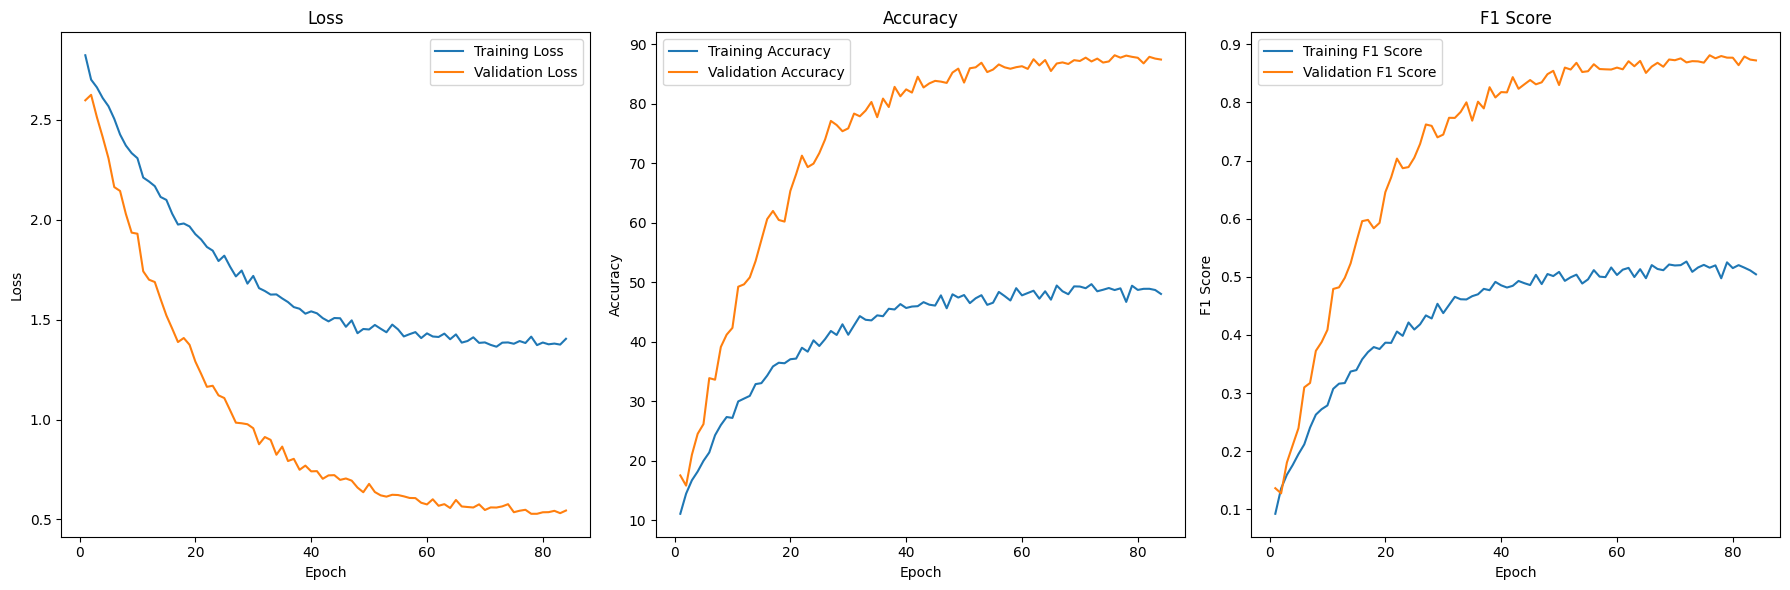

In [20]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

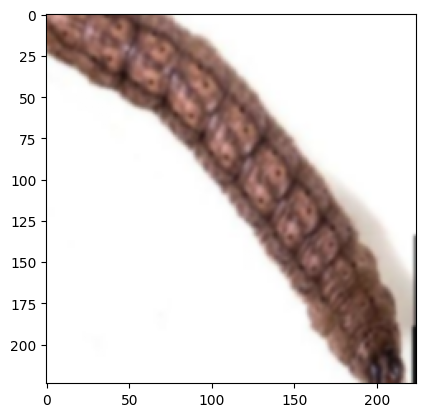

In [22]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()

In [23]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [25]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [27]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_resnet.csv")
sub

,class
id,
0,Cutworm
1,Jute Hairy
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Jute Hairy
1083,Jute Stem Girdler
